In [41]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model, applications, optimizers
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

In [ ]:
# 1. Configuration
CSV_PATH = "processed_dataset/videos_metadata.csv"
BATCH_SIZE = 8
IMG_SIZE = 128  
NUM_FRAMES = 30 

print(f"TensorFlow Version: {tf.__version__}")
print(f"GPU Available: {len(tf.config.list_physical_devices('GPU')) > 0}")

TensorFlow Version: 2.19.0
GPU Available: False


In [ ]:
# 2. Data Loading
df = pd.read_csv(CSV_PATH)
df['file_path'] = df['file_path'].apply(lambda x: x.replace('\\', os.sep)) 

# Create Splits
train_df = df[df["split"] == "train"]
val_df   = df[df["split"] == "val"]
test_df  = df[df["split"] == "test"]

def load_npy_file(path, label):
    # Load video (Shape: Variable frames, 64, 64, 3)
    video = np.load(path.numpy().decode("utf-8")) 
    
    # Sampling Strategy: Force exactly 30 frames
    total_frames = video.shape[0]
    target_frames = NUM_FRAMES
    
    if total_frames == target_frames:
        sampled_video = video
    else:
        # Uniformly sample indices
        indices = np.linspace(0, total_frames - 1, target_frames).astype(int)
        sampled_video = video[indices]
        
    # Note: Data is already 0.0-1.0 from preprocessing. Do NOT divide by 255 again.
    return sampled_video.astype("float32"), np.int32(label)

In [44]:
def tf_load_npy(path, label):
    video, label = tf.py_function(load_npy_file, [path, label], [tf.float32, tf.int32])
    video.set_shape((NUM_FRAMES, 64, 64, 3))
    label.set_shape(())
    return video, label

# --- Helper: Data Augmentation ---
def augment_video(video, label):
    # Random Flip (Horizontal)
    video = tf.image.random_flip_left_right(video)
    # Random Brightness
    video = tf.image.random_brightness(video, max_delta=0.1)
    return video, label

In [45]:
# --- Dataset Builder ---
def build_dataset(dataframe, shuffle=True, augment=False):
    paths = dataframe["file_path"].values
    labels = dataframe["label"].values
    
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    if shuffle:
        ds = ds.shuffle(len(dataframe))
    
    ds = ds.map(tf_load_npy, num_parallel_calls=tf.data.AUTOTUNE)
    
    if augment:
        ds = ds.map(augment_video, num_parallel_calls=tf.data.AUTOTUNE)
        
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

In [ ]:
# Create Pipelines
train_ds = build_dataset(train_df, shuffle=True, augment=True)
val_ds   = build_dataset(val_df, shuffle=False, augment=False)
test_ds  = build_dataset(test_df, shuffle=False, augment=False)

num_classes = df["label"].nunique()
print(f"Classes: {num_classes}")

Classes: 5


In [47]:
# 3. Build Model (MobileNetV2 Transfer)
# ==========================================
def build_mobilenet_transfer_model():
    # Input: (30 frames, 64x64 images, 3 channels)
    inputs = layers.Input(shape=(NUM_FRAMES, 64, 64, 3))
    
    # Preprocessing: Resize 64->128, Rescale 0..1 -> -1..1
    x = layers.TimeDistributed(layers.Resizing(IMG_SIZE, IMG_SIZE))(inputs)
    x = layers.TimeDistributed(layers.Rescaling(2.0, offset=-1.0))(x)
    
    # MobileNetV2 Base (Frozen)
    base_model = applications.MobileNetV2(
        include_top=False, 
        weights='imagenet', 
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
        pooling='avg' # Flattens output to (1280,) per frame
    )
    base_model.trainable = False 
    
    # Apply to all frames
    x = layers.TimeDistributed(base_model)(x)
    
    # Aggregate features (Average across 30 frames)
    x = layers.GlobalAveragePooling1D()(x)
    
    # Classifier Head
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    
    return Model(inputs, outputs, name="MobileNetV2_Transfer")

model = build_mobilenet_transfer_model()
model.summary()

Model: "MobileNetV2_Transfer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 30, 64, 64, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_15             │ (None, 30, 128, 128,   │             0 │
│ (TimeDistributed)               │ 3)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_16             │ (None, 30, 128, 128,   │             0 │
│ (TimeDistributed)               │ 3)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_17             │ (None, 30, 1280)       │     2,257,984 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_5      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,587,205 (9.87 MB)

 Trainable params: 329,221 (1.26 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [48]:
# 4. Phase 1: Initial Training
# ==========================================
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.0005),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

print("\nStarting Phase 1: Initial Training...")
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)


Starting Phase 1: Initial Training...
Epoch 1/10


70/70 ━━━━━━━━━━━━━━━━━━━━ 365s 3s/step - accuracy: 0.2954 - loss: 1.8684 - val_accuracy: 0.6087 - val_loss: 1.0009
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 230s 3s/step - accuracy: 0.6535 - loss: 0.8630 - val_accuracy: 0.7130 - val_loss: 0.7049
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 199s 3s/step - accuracy: 0.7547 - loss: 0.6571 - val_accuracy: 0.7391 - val_loss: 0.6345
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 187s 3s/step - accuracy: 0.7981 - loss: 0.5361 - val_accuracy: 0.7826 - val_loss: 0.5914
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 198s 3s/step - accuracy: 0.8720 - loss: 0.3745 - val_accuracy: 0.7652 - val_loss: 0.5567
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 220s 3s/step - accuracy: 0.8724 - loss: 0.3798 - val_accuracy: 0.7391 - val_loss: 0.6178
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 223s 3s/step - accuracy: 0.8877 - loss: 0.3097 - val_accuracy: 0.7913 - val_loss: 0.5219
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 205s 3s/step - accuracy: 0.9229 - loss: 0.2373 - val_accuracy: 0.7826 - val_loss: 0.

In [59]:
# 5. Phase 2: Fine-Tuning
print("\nStarting Phase 2: Fine-Tuning...")

base_model = model.layers[3].layer 

base_model.trainable = True

fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-5),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

history_fine = model.fit(
    train_ds,
    validation_data=val_ds,
    initial_epoch=history.epoch[-1],
    epochs=20 
)


Starting Phase 2: Fine-Tuning...
Epoch 10/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1788s 23s/step - accuracy: 0.8098 - loss: 0.5564 - val_accuracy: 0.7304 - val_loss: 0.6030
Epoch 11/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1314s 19s/step - accuracy: 0.8507 - loss: 0.4342 - val_accuracy: 0.7565 - val_loss: 0.5671
Epoch 12/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1284s 18s/step - accuracy: 0.8470 - loss: 0.3905 - val_accuracy: 0.7565 - val_loss: 0.5422
Epoch 13/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1579s 22s/step - accuracy: 0.8845 - loss: 0.3356 - val_accuracy: 0.7391 - val_loss: 0.5298
Epoch 14/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1399s 20s/step - accuracy: 0.9125 - loss: 0.2776 - val_accuracy: 0.7304 - val_loss: 0.5369
Epoch 15/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1465s 21s/step - accuracy: 0.8915 - loss: 0.3010 - val_accuracy: 0.7565 - val_loss: 0.5210
Epoch 16/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1555s 22s/step - accuracy: 0.9317 - loss: 0.2174 - val_accuracy: 0.7739 - val_loss: 0.5056
Epoch 17/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1901s 27s/step - 

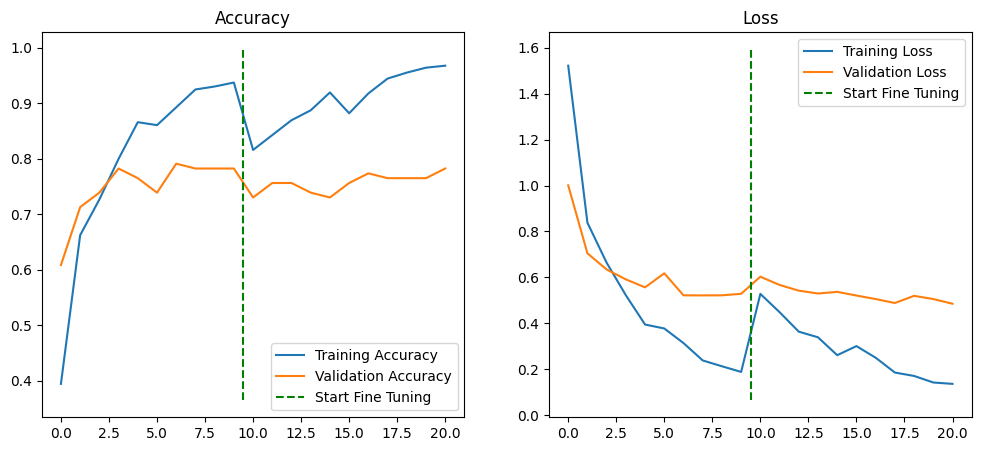

In [60]:
# 6. Combined Visualization
# ==========================================
acc = history.history['accuracy'] + history_fine.history['accuracy']
val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']
loss = history.history['loss'] + history_fine.history['loss']
val_loss = history.history['val_loss'] + history_fine.history['val_loss']

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.plot([9.5, 9.5], plt.ylim(), label='Start Fine Tuning', linestyle='--', color='green')
plt.legend(loc='lower right')
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.plot([9.5, 9.5], plt.ylim(), label='Start Fine Tuning', linestyle='--', color='green')
plt.legend(loc='upper right')
plt.title('Loss')
plt.show()

In [61]:
print("\nRunning Final Evaluation on Test Set...")

# Get Predictions
y_true = []
y_probs = []

for videos, labels in test_ds:
    probs = model.predict(videos, verbose=0)
    y_true.extend(labels.numpy())
    y_probs.append(probs)

y_true = np.array(y_true)
y_probs = np.concatenate(y_probs, axis=0)
y_pred = np.argmax(y_probs, axis=1)

# Metrics
acc = accuracy_score(y_true, y_pred)
print(f"\nFinal Test Accuracy: {acc*100:.2f}%")

# Class Names
label_to_name = df[["label", "gesture"]].drop_duplicates().set_index("label")["gesture"].to_dict()
class_names = [label_to_name[i] for i in range(num_classes)]

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))


Running Final Evaluation on Test Set...

Final Test Accuracy: 75.65%

Classification Report:
              precision    recall  f1-score   support

  Left_Swipe       0.55      0.48      0.51        23
 Right_Swipe       0.67      0.67      0.67        24
        Stop       0.78      0.91      0.84        23
 Thumbs_Down       0.92      0.92      0.92        24
   Thumbs_Up       0.85      0.81      0.83        21

    accuracy                           0.76       115
   macro avg       0.75      0.76      0.75       115
weighted avg       0.75      0.76      0.75       115



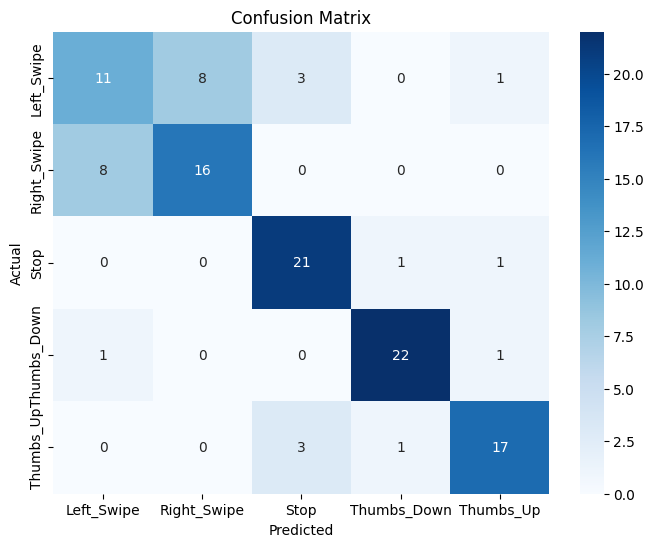

In [62]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

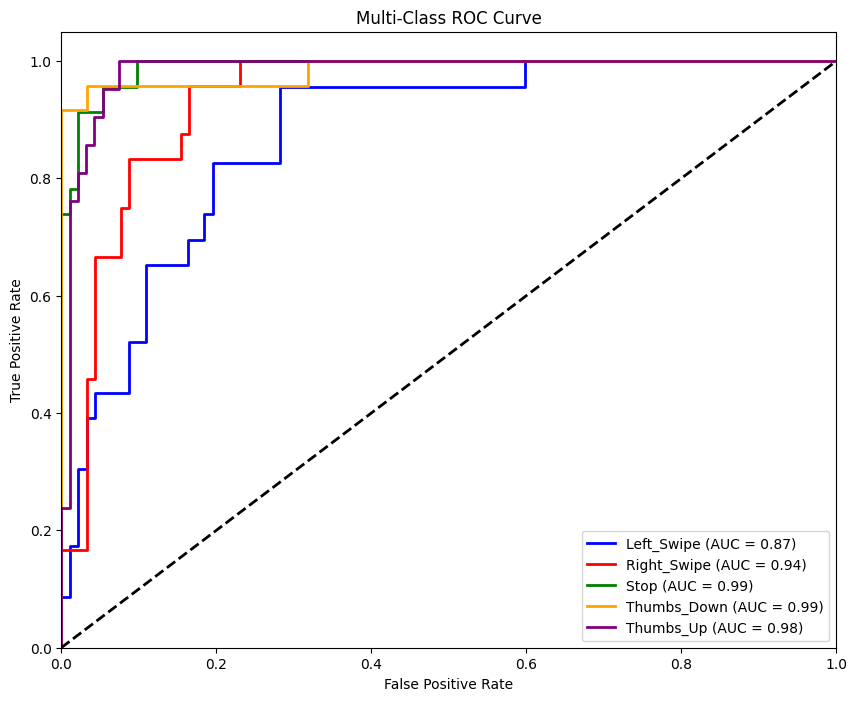

In [63]:
# ROC & AUC
y_true_bin = label_binarize(y_true, classes=range(num_classes))
fpr = dict()
tpr = dict()
roc_auc = dict()

plt.figure(figsize=(10, 8))
colors = cycle(['blue', 'red', 'green', 'orange', 'purple'])

for i, color in zip(range(num_classes), colors):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve')
plt.legend(loc="lower right")
plt.show()